# Example Usage

This notebook demonstrates how one can use the implementation to compute core and alpha-core persistent homology of point clouds.

In [1]:
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from miniball import Miniball
import warnings
warnings.filterwarnings('ignore')

from core import core_alpha, core_cech
from datasets import sample_circle, sample_rectangle, sample_torus

In [2]:
rng = np.random.default_rng(seed=0)

In [3]:
def plot_point_cloud(X):
    fig = plt.figure()

    if X.shape[-1] == 2:
        ax = fig.add_subplot()
        ax.scatter(*X.T, s=10, color="black", alpha=0.5, edgecolor="none")
    elif X.shape[-1] == 3:
        ax = fig.add_subplot(projection="3d")
        ax.scatter(*X.T, alpha=0.2, color="black", s=5, edgecolor="none")
        
    else:
        raise ValueError(f"Point cloud must be of dimension 2 or 3, not {X.shape[-1]}.")

    ax.set_aspect("equal")
    ax.axis("off")
    plt.show()

## Core Persistent Homology of a Noisy Circle

We start by computing Core Čech persistence of a noisy sample from a circle. We only use $150$ points in this case.

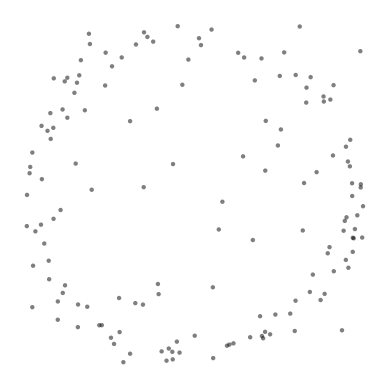

In [4]:
n = 100
m = 50
sigma = 0.05

Z = sample_circle(n, rng, r=1, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(m, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]
plot_point_cloud(X)

Here, we compute the core filtration for fixed values of $k$. We can achieve this by setting `max_r` to `None`. Note that the function `core_cech` returns squared filtration values, so we transform the filtration values by taking square roots before plotting the persistence diagrams.

1/3: k=1
2/3: k=5
3/3: k=10


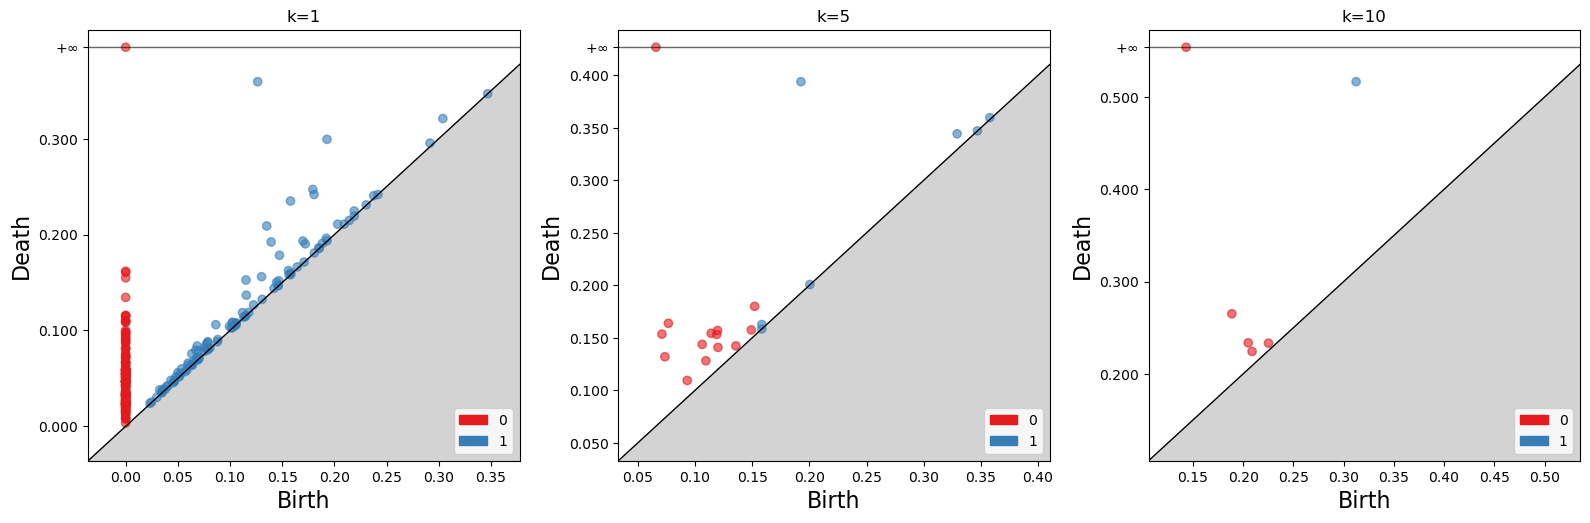

In [5]:
ks = [1, 5, 10]

fig, axs = plt.subplots(ncols=len(ks), figsize=(16, 16/len(ks)))

for i, k in enumerate(ks):
    print(f"{i+1}/{len(ks)}: k={k}")
    st_core = core_cech(X, max_k=k, max_r=None, max_dim=2)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"k={k}")

fig.tight_layout()
plt.show()

We see that the Core Čech agrees with the usual alpha complex when $k=1$ as expected. (Note that GUDHI's implementation of the alpha-complex also returns squared filtration values, so we do not need to transform the filtration values of the core Čech filtration here.)

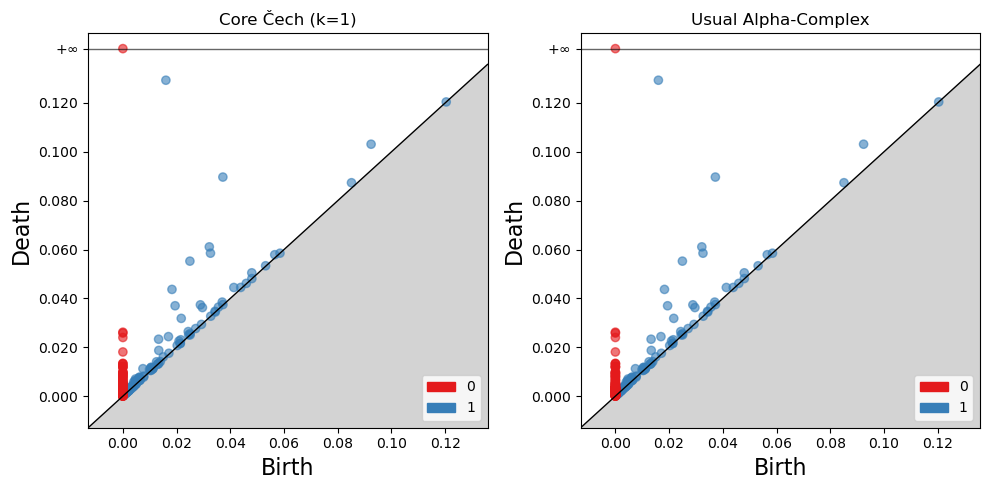

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

st_core = core_cech(X, max_k=1, max_r=None, max_dim=2)
core_pers = st_core.persistence()
gudhi.plot_persistence_diagram(core_pers, axes=axs[0])
axs[0].set_title(f"Core Čech (k=1)")

st_alpha = gudhi.AlphaComplex(X, precision="exact").create_simplex_tree()
alpha_pers = st_alpha.persistence()
gudhi.plot_persistence_diagram(alpha_pers, axes=axs[1])
axs[1].set_title(f"Usual Alpha-Complex")

fig.tight_layout()
plt.show()

We now compute core persistence along the line passing through the points `(0, max_k)` and `(max_r, 0)`. By setting `max_r` to `-1`, the value of `max_r` will automatically be set to the diameter of the input point cloud.

max_r = 2.5857
1/3: max_k=1
2/3: max_k=5
3/3: max_k=10


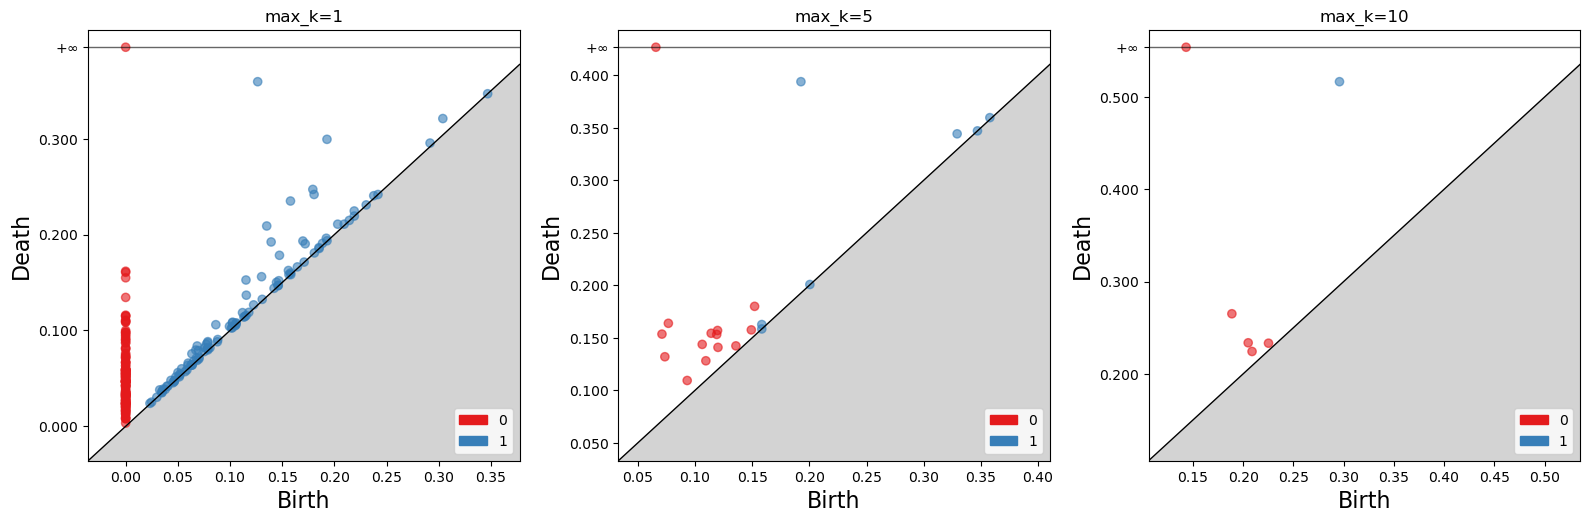

In [7]:
max_ks = [1, 5, 10]
max_r = 2 * Miniball(X).squared_radius() ** 0.5
print(f"max_r = {max_r:.4f}")

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(16, 16/len(max_ks)))

for i, max_k in enumerate(max_ks):
    print(f"{i+1}/{len(max_ks)}: max_k={max_k}")
    st_core = core_cech(X, max_k=max_k, max_r=max_r, max_dim=2)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"max_k={max_k}")

fig.tight_layout()
plt.show()

## Alpha-Core Persistent Homology of two Noisy Circles

We now compute the alpha version with a larger input point cloud.

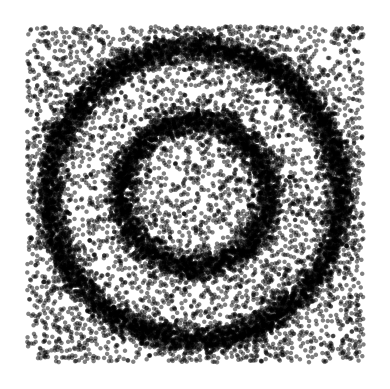

In [8]:
n = 10000
m = 5000
sigma = 0.05

Z = np.r_[sample_circle(2 * n // 3, rng, r=1, std=sigma), sample_circle(n // 3, rng, r=0.5, std=sigma)]
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(m, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]
plot_point_cloud(X)

We first compute the alpha-core for fixed values of $k$.

1/5: k=1
2/5: k=5
3/5: k=10
4/5: k=50
5/5: k=100


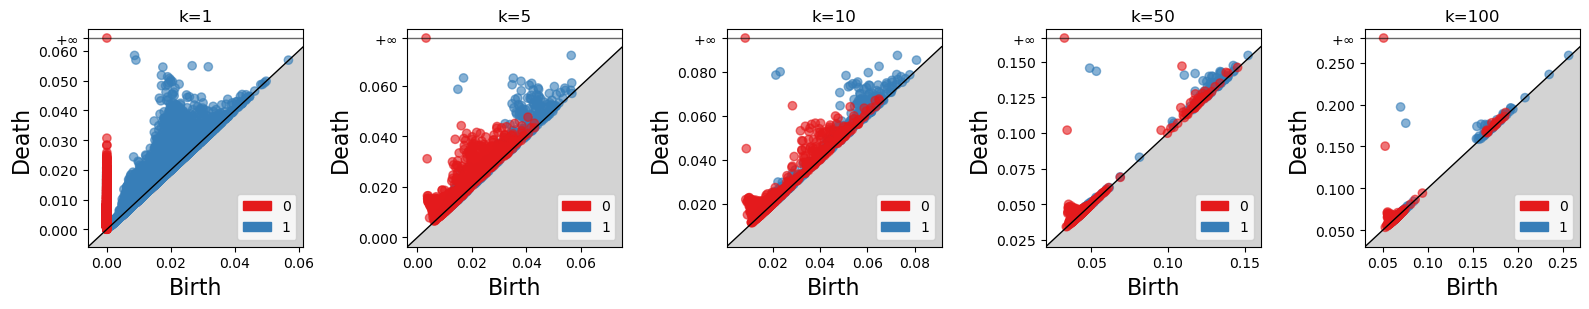

In [9]:
ks = [1, 5, 10, 50, 100]

fig, axs = plt.subplots(ncols=len(ks), figsize=(16, 16/len(ks)))

for i, k in enumerate(ks):
    print(f"{i+1}/{len(ks)}: k={k}")
    st_core = core_alpha(X, max_k=k, max_r=None)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"k={k}")

fig.tight_layout()
plt.show()

We now compute the alpha-core persistent homology along a line, again using `max_r` equal to the diameter of the input point cloud.

max_r = 3.1890
1/5: max_k=1
2/5: max_k=5
3/5: max_k=10
4/5: max_k=50
5/5: max_k=100


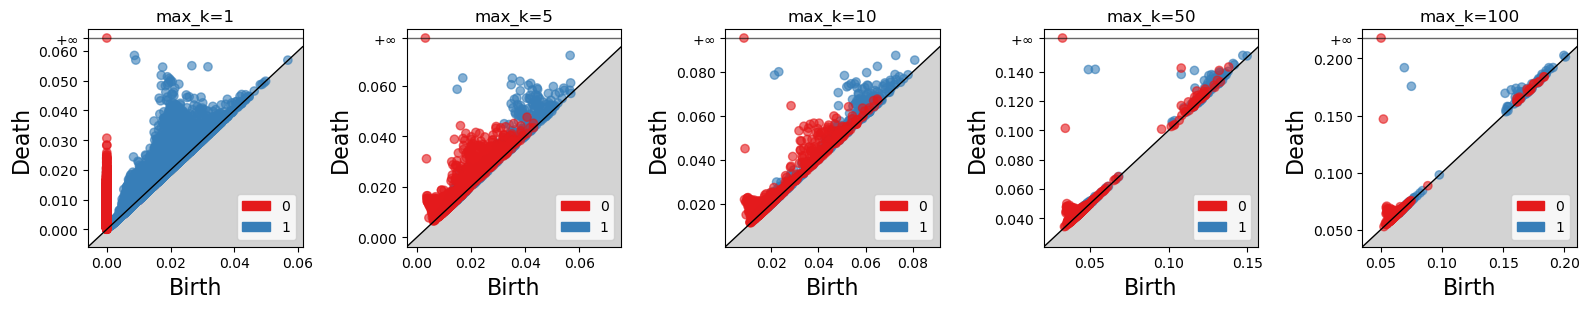

In [10]:
max_ks = [1, 5, 10, 50, 100]
max_r = 2 * Miniball(X).squared_radius() ** 0.5
print(f"max_r = {max_r:.4f}")

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(16, 16/len(max_ks)))

for i, max_k in enumerate(max_ks):
    print(f"{i+1}/{len(max_ks)}: max_k={max_k}")
    st_core = core_alpha(X, max_k=max_k, max_r=max_r)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"max_k={max_k}")

fig.tight_layout()
plt.show()

## Alpha-Core Persistent Homology of a Torus

We do the same as above, but with a noisy point cloud sampled from a torus embedded in $\mathbb{R}^3$.

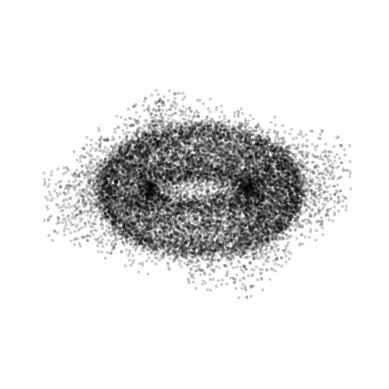

In [11]:
n = 10000
m = 5000
sigma = 0.05

Z = sample_torus(n, rng, std=sigma)
upper_right_corner = np.maximum(np.max(Z, axis=0), -np.min(Z, axis=0))
Y = sample_rectangle(m, rng, lower_left_corner=-upper_right_corner, upper_right_corner=upper_right_corner)
X = np.r_[Z, Y]
plot_point_cloud(X)

1/5: k=1
2/5: k=5
3/5: k=10
4/5: k=50
5/5: k=100


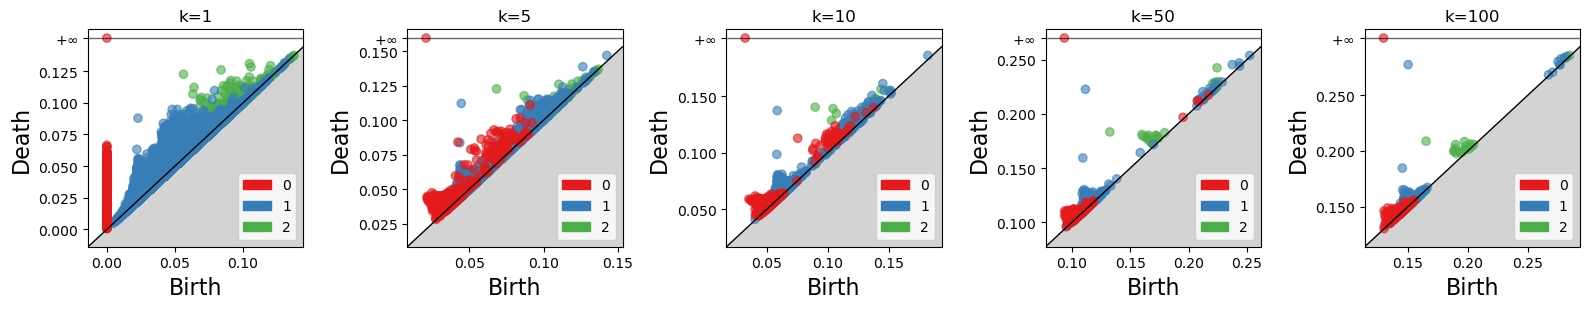

In [12]:
ks = [1, 5, 10, 50, 100]

fig, axs = plt.subplots(ncols=len(ks), figsize=(16, 16/len(ks)))

for i, k in enumerate(ks):
    print(f"{i+1}/{len(ks)}: k={k}")
    st_core = core_alpha(X, max_k=k, max_r=None)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"k={k}")

fig.tight_layout()
plt.show()

max_r = 3.2118
1/5: max_k=1
2/5: max_k=5
3/5: max_k=10
4/5: max_k=50
5/5: max_k=100


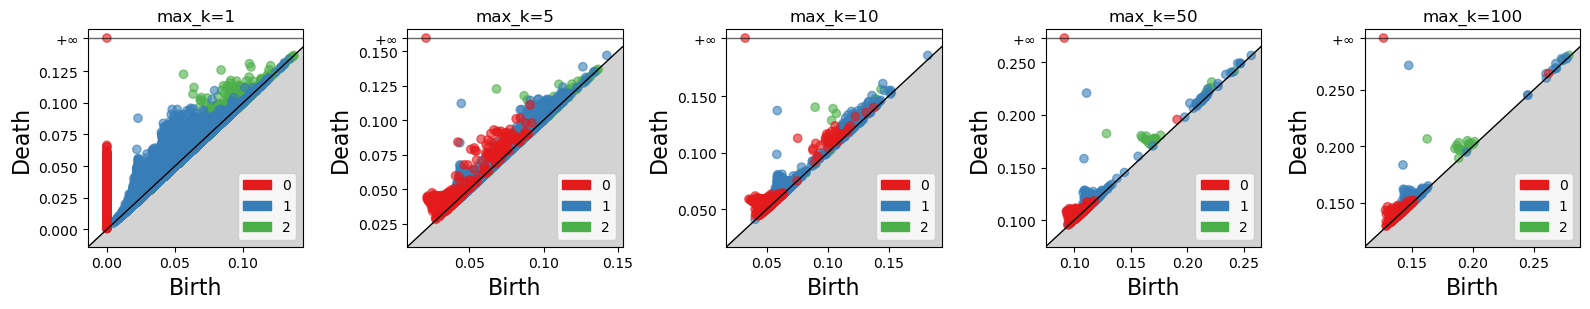

In [13]:
max_ks = [1, 5, 10, 50, 100]
max_r = 2 * Miniball(X).squared_radius() ** 0.5
print(f"max_r = {max_r:.4f}")

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(16, 16/len(max_ks)))

for i, max_k in enumerate(max_ks):
    print(f"{i+1}/{len(max_ks)}: max_k={max_k}")
    st_core = core_alpha(X, max_k=max_k, max_r=max_r)
    core_pers = st_core.persistence()
    core_pers = [(dim, (birth**0.5, death**0.5)) for dim, (birth, death) in core_pers]
    gudhi.plot_persistence_diagram(core_pers, axes=axs[i])
    axs[i].set_title(f"max_k={max_k}")

fig.tight_layout()
plt.show()